# ДЗ 1
## Классический МЛ в NLP, вспомнить все!

В этом ДЗ будем работать с датасетом Men_Women_Shoes_Reviews ttps://www.kaggle.com/daishinkan002/men-women-shoes-reviews 
 

### **Задание 1**. 
Предсказать цену по описанию товара (для каждого товара)
### **Задание 2.** 
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

## *Что нужно сделать в каждом задании:* 
1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) **1 балла**

3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) **0.5 балл**

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд,лучший результат показал лучший алгоритм **1 балл**

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) **1,5 балла** 

Максимальная сумма баллов при выполнении 5 пунктов в 2 заданиях - 10

В тетрадке с первого занятия много дополнительной информации, которая может вам помочь, но все равно не стесняйтесь приходить с вопросами в чат курса. 

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import re, regex
from scipy import stats
from collections import Counter
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from langdetect import detect
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot  as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
tokenizer = WordPunctTokenizer()
mystem_analyzer = Mystem()

[nltk_data] Downloading package punkt to /Users/pikachu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pikachu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pikachu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('./Shoes_Data.csv')

In [3]:
df.head(3)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


In [4]:
df['price'] = pd.to_numeric(df['price'].apply(lambda x: x.lstrip('₹')))
df['total_reviews'] = df['total_reviews'].apply(lambda x: 0 if re.findall('(.*?) ratings', x) == [] else re.findall('(.*?) ratings', x)[0])

 # 1. Предсказание цены по описанию товара (для каждого товара)

## 0.  Предобработка, чистка данных

## 1. Анализ данных

Отрисуем бокс-плотики, чтобы посмотреть, что там с таргетной ценой происходит

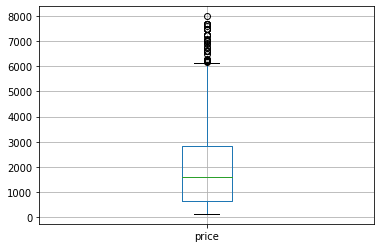

In [5]:
boxplot = df.boxplot(column=['price'])

Видим неприятную картину: куча выбросов, которые явно будут мешать жить

Отнормализуем данные

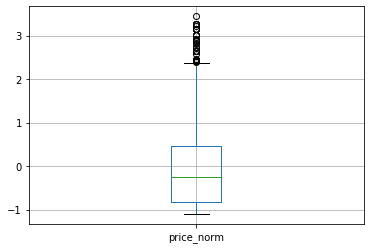

In [6]:
df['price_norm'] = (df.price-df.price.mean())/df.price.std()
boxplot = df.boxplot(column=['price_norm'])

Можно все привести к шкале от 0 до 1, но вариант выше мне понятнее, я им далее буду пользоваться

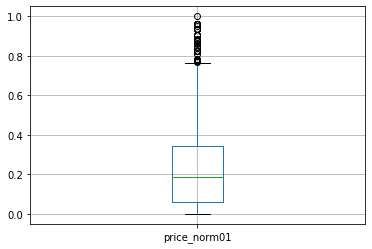

In [7]:
df['price_norm01'] = (df.price - df.price.min()) / (df.price.max() - df.price.min())
boxplot = df.boxplot(column=['price_norm01'])

Берем данные без выбросных значений и начинаем вечерину (предсказание по тексту цену товара)

In [8]:
df.head(2)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,price_norm,price_norm01
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9 out of 5 stars,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,-1.013540,0.019326
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.9 out of 5 stars,11520,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,-0.897895,0.044755


### Текстовые данные

Сделаем токенизацию, лемматизацию, уберем стоп-слова

Еще потом поотрезаем самые частотные и самые нечастотные токены и леммы (такая предпомощь веторизаторам) - избавляемся от слов, которые могут мешать либо опечатками, либо частотностью

In [9]:
def tokenize_line(line: str) -> str:
    to_tok = regex.sub(r'[^\p{Latin}]', u' ', line).lower()
    to_lem = ' '.join(tokenizer.tokenize(to_tok))
    return ''.join(to_lem)

def lemmatize_line(text: str) -> str:
    words = [w.lower() for w in mystem_analyzer.lemmatize(text)]
    words = [w for w in words if w not in stopwords_list]
    ans = re.sub('\n', '', ''.join(words))
    return ans

In [10]:
df['tokens'] = df['product_description'].apply(lambda x: tokenize_line(x))
df['lemmas'] = df['tokens'].apply(lambda x: lemmatize_line(x))

In [11]:
all_lemmas = []
for text in df['lemmas']:
    all_lemmas.extend(text.split())
c = Counter(all_lemmas)
to_del_lems = c.most_common(int(len(c)*0.02))
to_del_lems.extend(c.most_common()[-int(len(c)*0.03):])

In [12]:
def cleared(line: str, to_del) -> str:
    return ''.join([w for w in line if w not in to_del])

In [13]:
cleared_lemmas = []
for l in df['lemmas']:
    cleared_lemmas.append(cleared(l, to_del_lems))
df['cleared_lemmas'] = cleared_lemmas

In [14]:
all_tokens = []
for text in df['lemmas']:
    all_tokens.extend(text.split())
c = Counter(all_tokens)
to_del_toks = c.most_common(int(len(c)*0.02))
to_del_toks.extend(c.most_common()[-int(len(c)*0.03):])

cleared_tokens = []
for l in df['tokens']:
    cleared_tokens.append(cleared(l, to_del_lems))
df['cleared_tokens'] = cleared_tokens

Кажется, мы готовы к обучению моделей в задаче регрессии.
Хочу взять Линейную регрессию и RidgeCV).

In [15]:
df.head(1)

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,price_norm,price_norm01,tokens,lemmas,cleared_lemmas,cleared_tokens
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9 out of 5 stars,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,-1.01354,0.019326,elevate your style with this classy pair of ru...,elevate style classy pair running shoe h...,elevate style classy pair running shoe h...,elevate your style with this classy pair of ru...


In [16]:
vectorizer = TfidfVectorizer(analyzer='word')
vectorizer.fit_transform(df['cleared_lemmas'].to_numpy())

<1230x3783 sparse matrix of type '<class 'numpy.float64'>'
	with 45130 stored elements in Compressed Sparse Row format>

In [17]:
print(vectorizer.transform(['привет']).shape[1])
print(train.shape[0])

3783


NameError: name 'train' is not defined

У нас тут n_features > n_samples -> будет использоваться 'eigen' в gcv_mode

In [18]:
ridge = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('regressor', Ridge())])

train, test = train_test_split(df[['cleared_lemmas', 'price']], test_size=0.3, random_state=42)

In [19]:
parameters_ridge = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'regressor__normalize': (True, False)}

In [20]:
ridge = GridSearchCV(ridge, parameters_ridge, scoring='neg_mean_absolute_error', cv = 5)

ridge = ridge.fit(train['cleared_lemmas'], train['price'])
print(ridge.best_score_)
print(ridge.best_params_)

-698.91389669736
{'regressor__normalize': False, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
best_parameters = ridge.best_params_

In [22]:
best_parameters

{'regressor__normalize': False,
 'tfidf__smooth_idf': True,
 'tfidf__use_idf': True,
 'vectorizer__ngram_range': (1, 2)}

In [23]:
r = ridge.best_estimator_ 

In [24]:
predicted = r.predict(test['cleared_lemmas'])

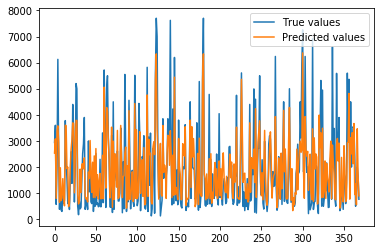

In [25]:
x = range(0, test['price'].shape[0])
plt.plot(x, test['price'], label = 'True values')
plt.plot(x, predicted, label = 'Predicted values')
plt.legend()

Видим, что часто модель скорее угадывает верный ответ, чем нет.

In [26]:
mse = mean_squared_error(test['price'], predicted)
mae = mean_absolute_error(test['price'], predicted)
print('MSE: ', '\n', mse)
print('MAE: ', '\n', mse)

MSE:  
 903460.8794378301
MAE:  
 903460.8794378301


Я бы лучше мерила что-то типа порядковости чисел, а не абсолютные числа, на самом деле. Но так тоже наглядно получается.

In [27]:
ridge = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('regressor', Ridge())])

train, test = train_test_split(df[['cleared_tokens', 'price']], test_size=0.3, random_state=42)

parameters_ridge = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'regressor__normalize': (True, False)}

ridge = GridSearchCV(ridge, parameters_ridge, scoring='neg_mean_absolute_error', cv = 5)

ridge = ridge.fit(train['cleared_tokens'], train['price'])
print(ridge.best_score_)
print(ridge.best_params_)
best_parameters = ridge.best_params_
r = ridge.best_estimator_ 
predicted = r.predict(test['cleared_tokens'])

-710.6670980931367
{'regressor__normalize': False, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
best_parameters

{'regressor__normalize': False,
 'tfidf__smooth_idf': True,
 'tfidf__use_idf': True,
 'vectorizer__ngram_range': (1, 2)}

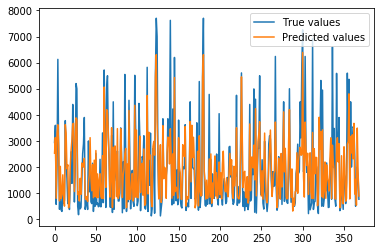

In [29]:
x = range(0, test['price'].shape[0])
plt.plot(x, test['price'], label = 'True values')
plt.plot(x, predicted, label = 'Predicted values')
plt.legend()

In [30]:
mse = mean_squared_error(test['price'], predicted)
mae = mean_absolute_error(test['price'], predicted)
print('MSE: ', '\n', mse)
print('MAE: ', '\n', mse)

MSE:  
 904466.6581078012
MAE:  
 904466.6581078012


На очищенных леммах получилось чуть лучше, хорошо, что мы посмотрели несколько вариантов.

Заметим, что в обоих случаях лучше всего брать как уни-, так и биграммы. Посмотрим далее, что посчитает нам линейная регрессия.


In [31]:
linear_regression = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('regressor', LinearRegression())])

In [32]:
parameters_linear_regression = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'regressor__normalize': (True, False)}

In [33]:
gs_lr = GridSearchCV(linear_regression, parameters_linear_regression, scoring='neg_mean_absolute_error', cv = 5)
train, test = train_test_split(df[['cleared_lemmas', 'price']], test_size=0.3, random_state=42)
gs_lr  = gs_lr .fit(train['cleared_lemmas'], train['price'])
print(gs_lr .best_score_)
print(gs_lr .best_params_)
best_parameters = gs_lr .best_params_
print(best_parameters)
r = gs_lr .best_estimator_ 
predicted = r.predict(test['cleared_lemmas'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-675.2171550194624
{'regressor__normalize': False, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}
{'regressor__normalize': False, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}


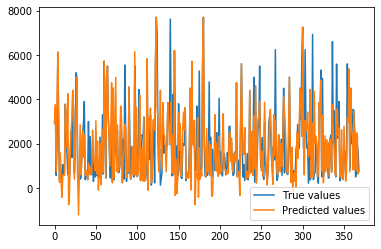

In [34]:
x = range(0, test['price'].shape[0])
plt.plot(x, test['price'], label = 'True values')
plt.plot(x, predicted, label = 'Predicted values')
plt.legend()

In [35]:
mse = mean_squared_error(test['price'], predicted)
mae = mean_absolute_error(test['price'], predicted)
print('MSE: ', '\n', mse)
print('MAE: ', '\n', mse)

MSE:  
 1263321.7411686315
MAE:  
 1263321.7411686315


In [36]:
gs_lr = GridSearchCV(linear_regression, parameters_linear_regression, scoring='neg_mean_absolute_error', cv = 5)
train, test = train_test_split(df[['cleared_tokens', 'price']], test_size=0.3, random_state=42)
gs_lr  = gs_lr .fit(train['cleared_tokens'], train['price'])
print(gs_lr .best_score_)
print(gs_lr .best_params_)
best_parameters = gs_lr .best_params_
print(best_parameters)
r = gs_lr .best_estimator_ 
predicted = r.predict(test['cleared_tokens'])

-659.3948017387235
{'regressor__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (2, 2)}
{'regressor__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (2, 2)}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


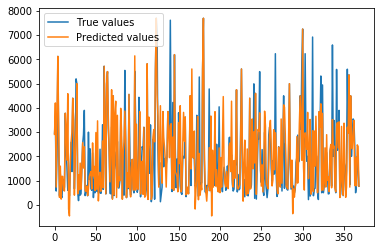

In [37]:
x = range(0, test['price'].shape[0])
plt.plot(x, test['price'], label = 'True values')
plt.plot(x, predicted, label = 'Predicted values')
plt.legend()

In [38]:
mse = mean_squared_error(test['price'], predicted)
mae = mean_absolute_error(test['price'], predicted)
print('MSE: ', '\n', mse)
print('MAE: ', '\n', mse)

MSE:  
 1178352.8073752106
MAE:  
 1178352.8073752106


Получилось похуже, что и ожидалось

Что в целом могло бы помочь повысить качество модели?

*  не обязательно использовать в качестве параметров только Tf-Idf описания товара, можно еще и другие колонки заиспользовать: мужские это или женские туфли? что пишут люди в комментариях про эту обувь?
* можно еще что-нибудь повертеть с текстовыми данными - постеммить и вообще поагментрировать/запросить больше данных
* как-нибудь облегчить задаче модель: не предсказывать конкретное число, а например, его логарифм - в целом, в жизни же людям привычнее покупать обувь определенной ценовой категории, а не цены :)


# 2. Предсказание оценки товара пользователем по его отзыву (для каждого отзыва)

Для начала просто проверим, что тагретные значения не пустые

In [39]:
df[df['rating'].notnull()].shape == df.shape

True

In [40]:
rating = []
total_reviews = []
reviews = []
reviews_rating = []
for i in range(df.shape[0]):
    rr = df['reviews_rating'][i].split('|| ')
    r = df['reviews'][i].split('|| ')
    for j in range(len(r)):
        reviews.append(r[j])
        reviews_rating.append(rr[j])
        rating.append(df['rating'][i])
        
        total_reviews.append(df['total_reviews'][i])

In [41]:
df_all = pd.DataFrame({'rating': rating, 
              'total_reviews': total_reviews,
              'reviews': reviews,
              'reviews_rating': reviews_rating})

df_all.head(3)

,rating,total_reviews,reviews,reviews_rating
0,2.9 out of 5 stars,2389,Not happy with product,1.0 out of 5 stars
1,2.9 out of 5 stars,2389,It's not as expected.,1.0 out of 5 stars
2,2.9 out of 5 stars,2389,AVERAGE PRODUCT,3.0 out of 5 stars


In [42]:
df = df_all

In [43]:
df['rating'] = df['rating'].apply(lambda x: float(re.findall('(.*?) out of', x)[0]))
df['reviews_rating'] = df['reviews_rating'].apply(lambda x: float(re.findall('(.*?) out of', x)[0]))

Посмотрим, как данные в целом распределены по классам.

In [44]:
df_ratings = pd.DataFrame(df[['reviews', 'reviews_rating']].groupby('reviews_rating').count())
df_ratings['reviews_rating'] = df_ratings.index

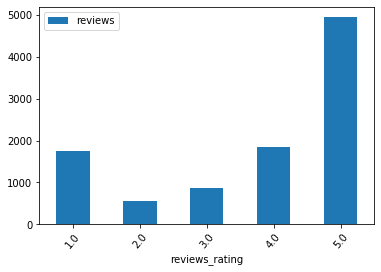

In [45]:
df_ratings.plot.bar(x='reviews_rating', y='reviews', rot=50)

Данные не очень сбалансированы, но посмотрим, что будут предсказывать модели)

Скорее всего, классы "2" и "3" будут существенно хуже определяться или определяться как какой-то другой (скорее всего, "1")

Для начала опять поработаем с текстовыми данными, есть еще там особенность в тем, что есть предложения на не-английском, их поубираем, тк они "шумовые".

Есть еще важный нюанс: если глазами отсмотреть оценки, то часто слово 'not' помогает какие-то отследить нехорошие оценки, поэтому уберем из стоп-слов это слово.

In [46]:
def lang_detect(line: str) -> str:
    try:
        lang = detect(line)
        return lang
    except:
        lang = 'unknown'
        return lang


In [47]:
lang_detect('hallo how are you dear')

'en'

In [48]:
stopwords_list.remove('not')

In [49]:
df['lang'] = df['reviews'].apply(lang_detect)

Тут прям видно, что хорошо бы оставить только английский

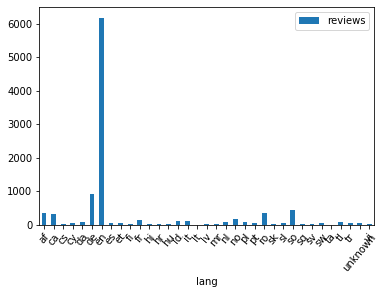

In [50]:
df_langs = pd.DataFrame(df[['reviews', 'lang']].groupby('lang').count())
df_langs['lang'] = df_langs.index

df_langs.plot.bar(x='lang', y='reviews', rot=50)

In [51]:
df.shape

(9958, 5)

In [52]:
df = df[df['lang'] == 'en']

In [53]:
df.shape

(6183, 5)

In [54]:
df['tokens'] = df['reviews'].apply(lambda x: tokenize_line(x))
df['lemmas'] = df['tokens'].apply(lambda x: lemmatize_line(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
df.head(3)

,rating,total_reviews,reviews,reviews_rating,lang,tokens,lemmas
0,2.9,2389,Not happy with product,1.0,en,not happy with product,not happy product
1,2.9,2389,It's not as expected.,1.0,en,it s not as expected,not expected
4,2.9,2389,Got damage product. But quality is average for...,3.0,en,got damage product but quality is average for,got damage product quality average


In [67]:
linear_regression = Pipeline([('vectorizer', TfidfVectorizer()),
                              ('regressor', LogisticRegression())])

parameters_log_regression = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
                             'vectorizer__min_df': [2,3,5],
                             'vectorizer__use_idf': (True, False),
                             'vectorizer__smooth_idf': (True, False),
                             'vectorizer__sublinear_tf': (True, False),
                             'regressor__C': [1.5,1.0,0.9]}

gs_log_regression = GridSearchCV(linear_regression, parameters_log_regression, scoring='neg_mean_absolute_error', cv = 5)
train, test = train_test_split(df[['lemmas', 'reviews_rating']], test_size=0.3, random_state=42)
gs_linear_regression = gs_log_regression.fit(train['lemmas'], train['reviews_rating'])
print(gs_log_regression.best_score_)
print(gs_log_regression.best_params_)
best_parameters = gs_log_regression.best_params_
print(best_parameters)
r = gs_log_regression.best_estimator_ 
predicted = r.predict(test['lemmas'])

-0.5986598890942699
{'regressor__C': 1.5, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}
{'regressor__C': 1.5, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}


In [57]:
print(classification_report(test['reviews_rating'], predicted))

              precision    recall  f1-score   support

         1.0       0.71      0.76      0.73       401
         2.0       0.45      0.12      0.19       110
         3.0       0.51      0.22      0.30       166
         4.0       0.44      0.18      0.26       319
         5.0       0.68      0.94      0.79       859

    accuracy                           0.66      1855
   macro avg       0.56      0.44      0.46      1855
weighted avg       0.62      0.66      0.61      1855



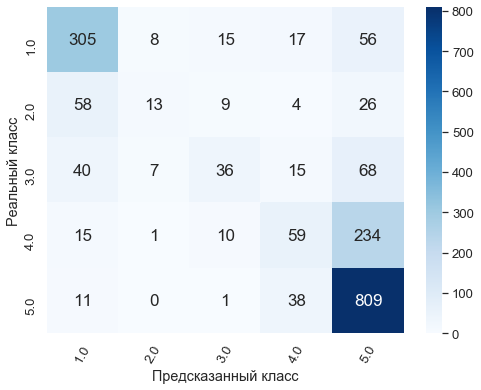

In [58]:
plt.figure(figsize=(8,6))
array=confusion_matrix(test['reviews_rating'], predicted)
a = [sorted(df['reviews_rating'].unique())]
df_cm = pd.DataFrame(array, index=a, columns=a)
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={'size':17}, cmap='Blues', fmt="d")
plt.xticks(rotation=60)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
plt.savefig('image_linregr.png')
plt.show()

Нельзя сказать, что модель как-то уж очень плохо справилась c классификацией, но это не образцовое решение. Почему? Посмотрели на classification_report, confusion_matrix, что заметили:
* оценка "2" чаще принималась за оценку "1" и, как ни странно, "5", что уж точно не должно быть! вохможно, стоило побольше почистить топ частотных слов (возможно, дело в этом)
* оценка "3" тоже достаточно смущает: модель принимала это чаще всего за "5", непосредственно "3" и, как ни странно, "1" - как будто действительно лексика виновата, ну а с другой стороны: ну все равно же люди по определенному паттерну составляют отзывы, возможно, надо побольше почистить слов как раз из-за таких особенностей, но важно тогда учитывать, чтобы мы не слишком много "отрезали"
* оценка "4" тоже скорее тяготеет к "5", что в целом не плохо совершенно, но и не очень приятно
* в целом, насколько я понимаю, это особенность модели: она сильнее штрафует, если мы вместо 1 предсказываем 4, а не 2, и нам по смыслу это подходит, но при этом с классом "3" как раз и возникает непонятка - куда его лучше относить

Прогоним то же самое, но на леммах, немножко почищенных от топ частотных и не частотных слов

In [69]:
all_lemmas = []
for text in df['lemmas']:
    all_lemmas.extend(text.split())
c = Counter(all_lemmas)
to_del_lems = c.most_common(int(len(c)*0.01))
to_del_lems.extend(c.most_common()[-int(len(c)*0.02):])

def cleared(line: str, to_del) -> str:
    return ''.join([w for w in line if w not in to_del])

cleared_lemmas = []
for l in df['lemmas']:
    cleared_lemmas.append(cleared(l, to_del_lems))
df['cleared_lemmas'] = cleared_lemmas

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
linear_regression = Pipeline([('vectorizer', TfidfVectorizer()),
                              ('regressor', LogisticRegression())])

parameters_log_regression = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
                             'vectorizer__min_df': [2,3,5],
                             'vectorizer__use_idf': (True, False),
                             'vectorizer__smooth_idf': (True, False),
                             'vectorizer__sublinear_tf': (True, False),
                             'regressor__C': [1.5,1.0,0.9]}

gs_log_regression = GridSearchCV(linear_regression, parameters_log_regression, scoring='neg_mean_absolute_error', cv = 5)
train, test = train_test_split(df[['cleared_lemmas', 'reviews_rating']], test_size=0.3, random_state=42)
gs_linear_regression = gs_log_regression.fit(train['cleared_lemmas'], train['reviews_rating'])
print(gs_log_regression.best_score_)
print(gs_log_regression.best_params_)
best_parameters = gs_log_regression.best_params_
print(best_parameters)
r = gs_log_regression.best_estimator_ 
predicted = r.predict(test['cleared_lemmas'])

-0.5986598890942699
{'regressor__C': 1.5, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}
{'regressor__C': 1.5, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}


In [72]:
print(classification_report(test['reviews_rating'], predicted))

              precision    recall  f1-score   support

         1.0       0.71      0.76      0.73       401
         2.0       0.45      0.12      0.19       110
         3.0       0.51      0.22      0.30       166
         4.0       0.44      0.18      0.26       319
         5.0       0.68      0.94      0.79       859

    accuracy                           0.66      1855
   macro avg       0.56      0.44      0.46      1855
weighted avg       0.62      0.66      0.61      1855



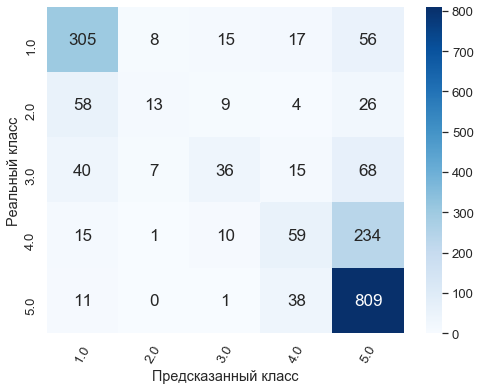

In [73]:
plt.figure(figsize=(8,6))
array=confusion_matrix(test['reviews_rating'], predicted)
a = [sorted(df['reviews_rating'].unique())]
df_cm = pd.DataFrame(array, index=a, columns=a)
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={'size':17}, cmap='Blues', fmt="d")
plt.xticks(rotation=60)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
plt.savefig('image_linregr.png')
plt.show()

Нет, это не супер помогло, да и в tf-idf и так были выставлены разные параметры, "подрезающие" слишком частотные/нечастотные слова

Попробуем MultinomialNB

Поучимся просто на леммах и посмотрим, что произошло

In [63]:
train, test = train_test_split(df[['lemmas', 'reviews_rating']], test_size=0.3, random_state=42)

nb = Pipeline([('vectorizer', TfidfVectorizer()),
 ('clf', MultinomialNB())])


parameters_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'vectorizer__use_idf': (True, False),
               'vectorizer__smooth_idf': (True, False),
               'vectorizer__sublinear_tf': (True, False),
               'clf__alpha': (100, 10, 1, 0.1,
                                         0.01, 0.001, 0)}
               
gs_clf_nb = GridSearchCV(nb, parameters_nb, n_jobs=-1, scoring = "f1_weighted")

gs_clf_nb = gs_clf_nb.fit(train['lemmas'], train['reviews_rating'])
print(gs_clf_nb.best_score_)
print(gs_clf_nb.best_params_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6217139591460311
{'clf__alpha': 0.1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__smooth_idf': True, 'vectorizer__sublinear_tf': False, 'vectorizer__use_idf': False}


In [64]:
r = gs_clf_nb.best_estimator_ 
predicted = r.predict(test['lemmas'])

In [65]:
print(classification_report(test['reviews_rating'], predicted))

              precision    recall  f1-score   support

         1.0       0.74      0.77      0.75       401
         2.0       0.49      0.17      0.26       110
         3.0       0.51      0.30      0.38       166
         4.0       0.49      0.26      0.34       319
         5.0       0.71      0.93      0.80       859

    accuracy                           0.68      1855
   macro avg       0.59      0.49      0.51      1855
weighted avg       0.65      0.68      0.64      1855



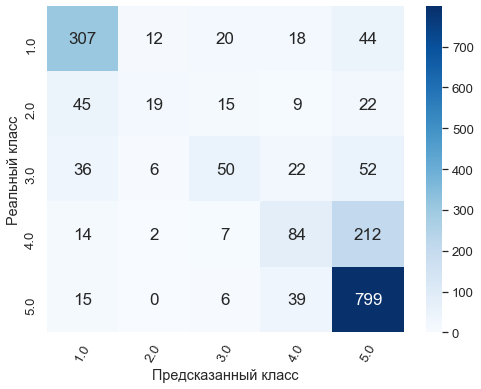

In [66]:
plt.figure(figsize=(8,6))
array=confusion_matrix(test['reviews_rating'], predicted)
a = [sorted(df['reviews_rating'].unique())]
df_cm = pd.DataFrame(array, index=a, columns=a)
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={'size':17}, cmap='Blues', fmt="d")
plt.xticks(rotation=60)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
plt.savefig('image_mnb.png')
plt.show()

В целом, все очень похоже на классификацию выше, что, безусловно, не так уж и плохо.

Класс "3" точнее определяется, меньше "2" тяготится к "1", а "4" к "5"

Все-таки для улучшения качества модели стоит побольше насобирать примеров отзывов с оценками "2" и "3№, да и в целом "4", чтобы "4" меньше определялся как "5".